# VulRAG-Hybrid System - Data Exploration

## 📊 Vulnerability Knowledge Base Analysis

### Overview
This notebook provides a comprehensive exploration of the VulRAG knowledge base, which contains information on security vulnerabilities categorized by CWE (Common Weakness Enumeration).

### Objectives
- Analyze the structure and content of the knowledge base
- Identify patterns and trends in vulnerability data
- Assess data quality and consistency
- Provide insights to guide future analyses

### Data Structure
- **10 CWE categories** with their associated vulnerabilities
- **JSON format**: Each file contains CVEs with their instances
- **Hierarchy**: CWE → CVE → Vulnerability instances

---

## 1. Configuration and Imports

Configuration of the analysis environment with the necessary libraries for data processing and visualization.

In [7]:
# VulRAG-Hybrid System - Data Exploration
# Notebook 01: VulRAG Knowledge Base Structure Analysis

import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
from collections import defaultdict, Counter
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

# Set up paths
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
DATA_RAW = PROJECT_ROOT / 'data' / 'raw'
VULRAG_KB = DATA_RAW / 'vulrag_kb'
METADATA_PATH = PROJECT_ROOT / 'data' / 'tmp' / 'temp_code_files' / 'metadata.json'
OUTPUT_PATH = PROJECT_ROOT / 'data' / 'processed' / 'kb1.json'

print(f"Project root: {PROJECT_ROOT}")
print(f"VulRAG KB directory: {VULRAG_KB}")

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Create results directory if needed
results_dir = PROJECT_ROOT / 'results' / 'exploration'
results_dir.mkdir(parents=True, exist_ok=True)

Project root: /Users/vernetemmanueladjobi/Documents/RessourcesStages/Projets/VulRAG-Hybrid-System
VulRAG KB directory: /Users/vernetemmanueladjobi/Documents/RessourcesStages/Projets/VulRAG-Hybrid-System/data/raw/vulrag_kb


## 2. Verifying Data Availability

Verifying the presence and size of files in the VulRAG knowledge base.

In [8]:
# Check VulRAG KB availability
print("Checking VulRAG Knowledge Base availability...")

if VULRAG_KB.exists():
    kb_files = list(VULRAG_KB.glob("*.json"))
    print(f"Found {len(kb_files)} KB files:")
    for file in sorted(kb_files):
        file_size = file.stat().st_size / 1024  # KB
        print(f"  {file.name} ({file_size:.1f} KB)")
else:
    print("ERROR: VulRAG KB directory not found")
    print("Please run: ./download_data.sh")
    raise FileNotFoundError("VulRAG KB not available")

print(f"\nReady to analyze {len(kb_files)} CWE knowledge bases")

Checking VulRAG Knowledge Base availability...
Found 10 KB files:
  gpt-4o-mini_CWE-119_316.json (1696.7 KB)
  gpt-4o-mini_CWE-125_316.json (1503.3 KB)
  gpt-4o-mini_CWE-200_316.json (1312.1 KB)
  gpt-4o-mini_CWE-20_316.json (1759.1 KB)
  gpt-4o-mini_CWE-264_316.json (1094.5 KB)
  gpt-4o-mini_CWE-362_316.json (3007.8 KB)
  gpt-4o-mini_CWE-401_316.json (831.1 KB)
  gpt-4o-mini_CWE-416_316.json (5882.9 KB)
  gpt-4o-mini_CWE-476_316.json (2621.1 KB)
  gpt-4o-mini_CWE-787_316.json (2035.0 KB)

Ready to analyze 10 CWE knowledge bases



## 3. VulRAG Knowledge Base Structure Analysis

Detailed exploration and validation of the VulRAG knowledge base structure, including summary statistics and consistency checks.
```

In [9]:
def load_vulrag_kb():
    """Load all KB files and analyze structure"""
    print("="*60)
    print(" KNOWLEDGE BASE ANALYSIS")
    print("="*60)
    
    kb_data = {}
    total_cves = 0
    total_instances = 0
    global_cve_data = {}
    cwe_categories = set()
    
    for kb_file in sorted(VULRAG_KB.glob("*.json")):
        # Extract CWE from filename: gpt-4o-mini_CWE-119_316.json
        cwe = kb_file.stem.split('_')[1]  # CWE-119
        cwe_categories.add(cwe)
        
        try:
            with open(kb_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            cwe_cve_count = 0
            cwe_instance_count = 0
            cwe_cve_data = {}
            
            # Iterate over all CVEs in this CWE file
            for cve_id, instances in data.items():
                instances_count = len(instances)
                
                # Update counters
                total_cves += 1
                cwe_cve_count += 1
                total_instances += instances_count
                cwe_instance_count += instances_count
                
                # Store CVE information
                cve_info = {
                    'cwe': cwe,
                    'instances_count': instances_count,
                    'file': kb_file.name
                }
                
                global_cve_data[cve_id] = cve_info
                cwe_cve_data[cve_id] = instances_count
            
            # Store data by CWE
            kb_data[cwe] = {
                'file': kb_file.name,
                'cve_count': cwe_cve_count,
                'instance_count': cwe_instance_count,
                'cve_list': cwe_cve_data
            }
            
        except Exception as e:
            print(f"ERROR loading {kb_file.name}: {e}")
            continue
    
    # Add global statistics (no date)
    kb_data['_summary'] = {
        'total_cves': total_cves,
        'total_instances': total_instances,
        'total_cwe_categories': len(cwe_categories),
        'all_cve_data': global_cve_data
    }
    
    return kb_data

def display_analysis(kb_data):
    """Display formatted analysis"""
    summary = kb_data.get('_summary', {})
    
    print(f"GLOBAL SUMMARY:")
    print(f"   • {summary.get('total_cwe_categories', 0)} CWE categories")
    print(f"   • {summary.get('total_cves', 0)} unique CVEs")
    print(f"   • {summary.get('total_instances', 0)} function instances")
    
    print("\n" + "="*60)
    print("DETAIL BY CWE CATEGORY")
    print("="*60)
    
    for cwe, info in kb_data.items():
        if cwe.startswith('_'):  # Skip metadata
            continue
            
        print(f"\n{cwe} has {info['cve_count']} CVEs (file: {info['file']})")
        print(f"   Total instances: {info['instance_count']}")
        print(f"   Average: {info['instance_count']/info['cve_count']:.1f} instances/CVE")
        print("   CVE list:")
        
        # Sort CVEs by number of instances (descending)
        sorted_cves = sorted(info['cve_list'].items(), key=lambda x: x[1], reverse=True)
        
        for cve_id, instances_count in sorted_cves:
            if instances_count > 3:
                indicator = "[HIGH]"
            elif instances_count > 1:
                indicator = "[MED]"
            else:
                indicator = "[LOW]"
            print(f"      {indicator} {cve_id}: {instances_count} instance{'s' if instances_count > 1 else ''}")

def save_to_json(kb_data, output_file):
    """Save analysis to JSON file"""
    try:
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(kb_data, f, indent=2, ensure_ascii=False)
        print(f"\nAnalysis saved to: {output_file}")
        return True
    except Exception as e:
        print(f"Error while saving: {e}")
        return False

def generate_summary_report(kb_data, output_file):
    """Generate a summary report"""
    summary = kb_data.get('_summary', {})
    
    # Create a summary report 
    report = {
        "analysis_metadata": {
            "total_cwe_categories": summary.get('total_cwe_categories'),
            "total_cves": summary.get('total_cves'),
            "total_instances": summary.get('total_instances')
        },
        "cwe_breakdown": {},
        "top_cves_by_instances": {},
        "statistics": {}
    }
    
    # Breakdown by CWE
    for cwe, info in kb_data.items():
        if cwe.startswith('_'):
            continue
        report["cwe_breakdown"][cwe] = {
            "cve_count": info['cve_count'],
            "instance_count": info['instance_count'],
            "avg_instances_per_cve": round(info['instance_count']/info['cve_count'], 2),
            "file": info['file']
        }
    
    # Top CVEs by number of instances
    all_cves = summary.get('all_cve_data', {})
    top_cves = sorted(all_cves.items(), key=lambda x: x[1]['instances_count'], reverse=True)[:10]
    report["top_cves_by_instances"] = {
        cve: {"instances": data['instances_count'], "cwe": data['cwe']} 
        for cve, data in top_cves
    }
    
    # Statistics
    instance_counts = [data['instances_count'] for data in all_cves.values()]
    if instance_counts:
        report["statistics"] = {
            "avg_instances_per_cve": round(sum(instance_counts)/len(instance_counts), 2),
            "min_instances": min(instance_counts),
            "max_instances": max(instance_counts),
            "cves_with_multiple_instances": len([x for x in instance_counts if x > 1])
        }
    
    # Save
    try:
        with open(output_file, 'w', encoding='utf-8') as f:
            json.dump(report, f, indent=2, ensure_ascii=False)
        print(f"Summary report saved to: {output_file}")
        return True
    except Exception as e:
        print(f"Error while saving the report: {e}")
        return False

# Full usage
vulrag_data = load_vulrag_kb()
display_analysis(vulrag_data)
save_to_json(vulrag_data, results_dir/"vulrag_complete_analysis.json")
generate_summary_report(vulrag_data, results_dir/"vulrag_summary_report.json")
print("\nAnalysis completed!")


 KNOWLEDGE BASE ANALYSIS
GLOBAL SUMMARY:
   • 10 CWE categories
   • 1217 unique CVEs
   • 2317 function instances

DETAIL BY CWE CATEGORY

CWE-119 has 111 CVEs (file: gpt-4o-mini_CWE-119_316.json)
   Total instances: 173
   Average: 1.6 instances/CVE
   CVE list:
      [HIGH] CVE-2016-3134: 8 instances
      [HIGH] CVE-2013-1772: 7 instances
      [HIGH] CVE-2014-3184: 5 instances
      [HIGH] CVE-2017-18222: 4 instances
      [HIGH] CVE-2014-0205: 4 instances
      [MED] CVE-2012-3364: 3 instances
      [MED] CVE-2016-4998: 3 instances
      [MED] CVE-2017-5548: 3 instances
      [MED] CVE-2017-7895: 3 instances
      [MED] CVE-2013-2893: 3 instances
      [MED] CVE-2021-4204: 3 instances
      [MED] CVE-2011-4098: 3 instances
      [MED] CVE-2013-1860: 3 instances
      [MED] CVE-2016-8632: 3 instances
      [MED] CVE-2018-1120: 3 instances
      [MED] CVE-2014-3182: 2 instances
      [MED] CVE-2017-15126: 2 instances
      [MED] CVE-2012-6712: 2 instances
      [MED] CVE-2017-16996

VULRAG SUMMARY ANALYSIS
📊 OVERVIEW:
   • 10 CWE categories
   • 1,217 total CVEs
   • 2,317 total instances
   • 1.9 average instances per CVE

🔍 CWE BREAKDOWN:
Top 5 CWE by volume:
   1. CWE-416: 300 CVEs (24.7%) - 2.20 avg/CVE
   2. CWE-476: 163 CVEs (13.4%) - 1.72 avg/CVE
   3. CWE-362: 159 CVEs (13.1%) - 2.01 avg/CVE
   4. CWE-119: 111 CVEs (9.1%) - 1.56 avg/CVE
   5. CWE-787: 107 CVEs (8.8%) - 1.75 avg/CVE

⚡ COMPLEXITY ANALYSIS:
Most complex CWE (high instances/CVE):
   1. CWE-264: 2.93 instances/CVE (41 CVEs)
   2. CWE-20: 2.30 instances/CVE (79 CVEs)
   3. CWE-416: 2.20 instances/CVE (300 CVEs)

🚨 MOST COMPLEX CVEs:
CVEs requiring many fixes:
   1. CVE-2013-7266: 37 instances (CWE-20)
   2. CVE-2012-3552: 23 instances (CWE-362)
   3. CVE-2016-3841: 20 instances (CWE-416)
   4. CVE-2020-36694: 19 instances (CWE-416)
   5. CVE-2023-5633: 19 instances (CWE-416)

📈 KEY INSIGHTS:
   • 383 CVEs need multiple fixes (31.5%)
   • Range: 1-37 instances per CVE
   • Most complex CVE: CVE-

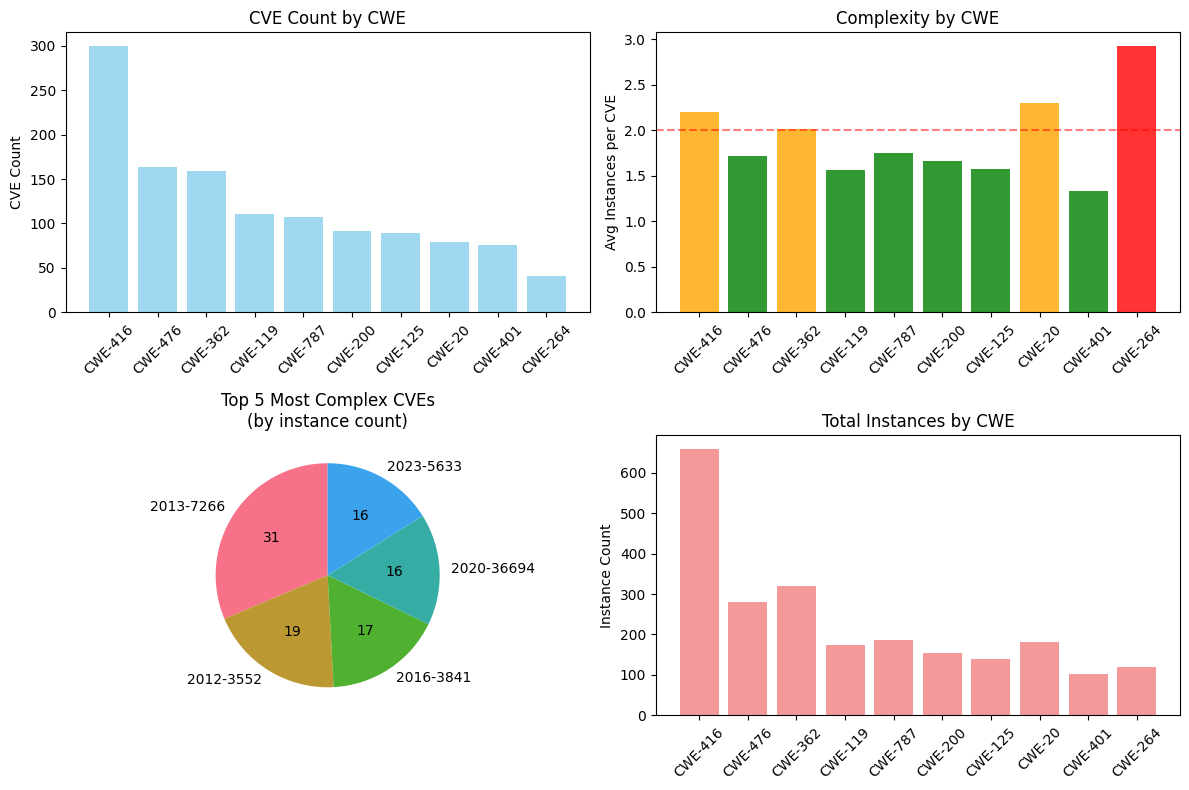


🎯 PATTERN ANALYSIS:
High volume CWEs (>100 CVEs): ['CWE-416', 'CWE-476', 'CWE-362', 'CWE-119', 'CWE-787']
High complexity CWEs (>2.0 avg): ['CWE-416', 'CWE-362', 'CWE-20', 'CWE-264']
CWE-416 dominance: 24.7% of all CVEs
Top complex CVEs distribution:
   CWE-416: 4 CVEs in top 10 most complex
   CWE-20: 2 CVEs in top 10 most complex
   CWE-362: 1 CVEs in top 10 most complex
   CWE-476: 1 CVEs in top 10 most complex
   CWE-200: 1 CVEs in top 10 most complex
   CWE-264: 1 CVEs in top 10 most complex


In [10]:


def load_and_analyze_summary(json_file="vulrag_summary_report.json"):
    """Load and analyze VulRAG summary JSON"""
    
    print("="*60)
    print("VULRAG SUMMARY ANALYSIS")
    print("="*60)
    
    # Load JSON data
    try:
        with open(json_file, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"❌ File {json_file} not found")
        return None
    
    # Extract key information
    metadata = data['analysis_metadata']
    cwe_breakdown = data['cwe_breakdown']
    top_cves = data['top_cves_by_instances']
    stats = data['statistics']
    
    # Display overview
    print(f"📊 OVERVIEW:")
    print(f"   • {metadata['total_cwe_categories']} CWE categories")
    print(f"   • {metadata['total_cves']:,} total CVEs")
    print(f"   • {metadata['total_instances']:,} total instances")
    print(f"   • {stats['avg_instances_per_cve']:.1f} average instances per CVE")
    
    # CWE analysis
    print(f"\n🔍 CWE BREAKDOWN:")
    cwe_df = pd.DataFrame(cwe_breakdown).T
    cwe_df = cwe_df.sort_values('cve_count', ascending=False)
    
    print("Top 5 CWE by volume:")
    for i, (cwe, row) in enumerate(cwe_df.head().iterrows(), 1):
        pct = (row['cve_count'] / metadata['total_cves']) * 100
        print(f"   {i}. {cwe}: {row['cve_count']} CVEs ({pct:.1f}%) - {row['avg_instances_per_cve']:.2f} avg/CVE")
    
    # Complexity analysis
    print(f"\n⚡ COMPLEXITY ANALYSIS:")
    complex_cwe = cwe_df.sort_values('avg_instances_per_cve', ascending=False)
    print("Most complex CWE (high instances/CVE):")
    for i, (cwe, row) in enumerate(complex_cwe.head(3).iterrows(), 1):
        print(f"   {i}. {cwe}: {row['avg_instances_per_cve']:.2f} instances/CVE ({row['cve_count']} CVEs)")
    
    # Top complex CVEs
    print(f"\n🚨 MOST COMPLEX CVEs:")
    print("CVEs requiring many fixes:")
    for i, (cve, info) in enumerate(list(top_cves.items())[:5], 1):
        print(f"   {i}. {cve}: {info['instances']} instances ({info['cwe']})")
    
    # Statistics insights
    print(f"\n📈 KEY INSIGHTS:")
    print(f"   • {stats['cves_with_multiple_instances']} CVEs need multiple fixes ({stats['cves_with_multiple_instances']/metadata['total_cves']*100:.1f}%)")
    print(f"   • Range: {stats['min_instances']}-{stats['max_instances']} instances per CVE")
    print(f"   • Most complex CVE: {list(top_cves.keys())[0]} with {stats['max_instances']} instances!")
    
    return data, cwe_df

def visualize_summary(data, cwe_df):
    """Create simple visualizations from summary data"""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
    
    # 1. CVE count by CWE
    ax1.bar(cwe_df.index, cwe_df['cve_count'], color='skyblue', alpha=0.8)
    ax1.set_title('CVE Count by CWE')
    ax1.set_ylabel('CVE Count')
    ax1.tick_params(axis='x', rotation=45)
    
    # 2. Complexity (avg instances per CVE)
    colors = ['red' if x > 2.5 else 'orange' if x > 2.0 else 'green' for x in cwe_df['avg_instances_per_cve']]
    ax2.bar(cwe_df.index, cwe_df['avg_instances_per_cve'], color=colors, alpha=0.8)
    ax2.set_title('Complexity by CWE')
    ax2.set_ylabel('Avg Instances per CVE')
    ax2.tick_params(axis='x', rotation=45)
    ax2.axhline(y=2.0, color='red', linestyle='--', alpha=0.5)
    
    # 3. Top CVEs pie chart
    top_cves = data['top_cves_by_instances']
    top_5_cves = list(top_cves.items())[:5]
    cve_names = [cve.replace('CVE-', '') for cve, _ in top_5_cves]
    cve_instances = [info['instances'] for _, info in top_5_cves]
    
    ax3.pie(cve_instances, labels=cve_names, autopct='%1.0f', startangle=90)
    ax3.set_title('Top 5 Most Complex CVEs\n(by instance count)')
    
    # 4. Instance distribution
    ax4.bar(cwe_df.index, cwe_df['instance_count'], color='lightcoral', alpha=0.8)
    ax4.set_title('Total Instances by CWE')
    ax4.set_ylabel('Instance Count')
    ax4.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def find_patterns(data, cwe_df):
    """Find interesting patterns in the data"""
    
    print(f"\n🎯 PATTERN ANALYSIS:")
    
    # Volume vs Complexity correlation
    high_volume = cwe_df[cwe_df['cve_count'] > 100]
    high_complexity = cwe_df[cwe_df['avg_instances_per_cve'] > 2.0]
    
    print(f"High volume CWEs (>100 CVEs): {list(high_volume.index)}")
    print(f"High complexity CWEs (>2.0 avg): {list(high_complexity.index)}")
    
    # CWE-416 dominance
    cwe_416_share = (cwe_df.loc['CWE-416', 'cve_count'] / data['analysis_metadata']['total_cves']) * 100
    print(f"CWE-416 dominance: {cwe_416_share:.1f}% of all CVEs")
    
    # Distribution of top CVEs by CWE
    top_cves_by_cwe = {}
    for cve, info in data['top_cves_by_instances'].items():
        cwe = info['cwe']
        if cwe not in top_cves_by_cwe:
            top_cves_by_cwe[cwe] = 0
        top_cves_by_cwe[cwe] += 1
    
    print(f"Top complex CVEs distribution:")
    for cwe, count in sorted(top_cves_by_cwe.items(), key=lambda x: x[1], reverse=True):
        print(f"   {cwe}: {count} CVEs in top 10 most complex")

# Usage
data, cwe_df = load_and_analyze_summary(results_dir/"vulrag_summary_report.json")
if data:
    visualize_summary(data, cwe_df)
    find_patterns(data, cwe_df)


## 4. Knowledge Base Structure Validation

This section performs a comprehensive validation of the VulRAG knowledge base structure. It checks for consistency across all CWE files, verifies the presence of required fields, and ensures that duplicated fields are correctly aligned. The validation report summarizes any structural issues or inconsistencies detected in the dataset.
```

In [11]:
def validate_all_knowledge_structure(kb_data):
    """Validate that all VulRAG files have consistent structure and check duplicated fields"""
    
    print("="*60)
    print("COMPREHENSIVE KNOWLEDGE STRUCTURE VALIDATION")
    print("="*60)
    
    # Expected structure based on first analysis
    expected_fields = set()
    expected_vulrag_dimensions = {
        'vulnerability_analysis': ['vulnerability_behavior', 'preconditions_for_vulnerability', 'trigger_condition', 'specific_code_behavior_causing_vulnerability'],
        'solution_knowledge': ['solution'],
        'semantic_analysis': ['GPT_analysis', 'GPT_purpose', 'GPT_function'],
        'code_evidence': ['code_before_change', 'code_after_change', 'modified_lines'],
        'metadata': ['CVE_id']
    }
    
    all_expected_fields = set()
    for fields_list in expected_vulrag_dimensions.values():
        all_expected_fields.update(fields_list)
    
    # Validation results
    validation_results = {
        'total_files': 0,
        'valid_files': 0,
        'structure_inconsistencies': [],
        'duplication_validation': {},
        'missing_fields_by_file': {},
        'extra_fields_by_file': {},
        'total_cves_validated': 0,
        'total_instances_validated': 0
    }
    
    duplicated_fields = ['preconditions_for_vulnerability', 'trigger_condition', 'specific_code_behavior_causing_vulnerability']
    
    print("Validating structure across all CWE files...")
    print(f"Expected duplicated fields: {duplicated_fields}")
    
    # Validate each CWE file
    for cwe, info in kb_data.items():
        if cwe.startswith('_'):  # Skip metadata
            continue
            
        validation_results['total_files'] += 1
        cwe_file = info['file']
        cwe_file_path = VULRAG_KB / cwe_file
        
        print(f"\nValidating {cwe} ({cwe_file})...")
        
        try:
            with open(cwe_file_path, 'r', encoding='utf-8') as f:
                cwe_data = json.load(f)
        except Exception as e:
            print(f"Error loading {cwe_file}: {e}")
            validation_results['structure_inconsistencies'].append(f"{cwe}: Failed to load file")
            continue
        
        file_validation = {
            'cve_count': len(cwe_data),
            'instance_count': 0,
            'structure_valid': True,
            'duplication_valid': True,
            'missing_fields': set(),
            'extra_fields': set(),
            'duplication_errors': []
        }
        
        # Validate each CVE in this file
        for cve_id, instances in cwe_data.items():
            validation_results['total_cves_validated'] += 1
            
            for instance_idx, instance in enumerate(instances):
                validation_results['total_instances_validated'] += 1
                file_validation['instance_count'] += 1
                
                # Check structure consistency
                instance_fields = set(instance.keys())
                
                # First file sets the expected structure
                if not expected_fields:
                    expected_fields = instance_fields.copy()
                    print(f"Reference structure established from {cwe}:{cve_id}[{instance_idx}]")
                    print(f"   Expected fields ({len(expected_fields)}): {sorted(expected_fields)}")
                
                # Check for missing/extra fields
                missing_fields = all_expected_fields - instance_fields
                extra_fields = instance_fields - expected_fields
                
                if missing_fields:
                    file_validation['missing_fields'].update(missing_fields)
                    file_validation['structure_valid'] = False
                
                if extra_fields:
                    file_validation['extra_fields'].update(extra_fields)
                
                # Validate duplicated fields content
                for dup_field in duplicated_fields:
                    if dup_field in instance:
                        # Check if field exists in vulnerability_behavior
                        vb = instance.get('vulnerability_behavior', {})
                        if isinstance(vb, dict) and dup_field in vb:
                            root_value = instance[dup_field]
                            vb_value = vb[dup_field]
                            
                            if root_value != vb_value:
                                error_msg = f"{cve_id}[{instance_idx}].{dup_field}: Content mismatch"
                                file_validation['duplication_errors'].append(error_msg)
                                file_validation['duplication_valid'] = False
                                print(f"    {error_msg}")
        
        # Store file validation results
        if file_validation['structure_valid']:
            validation_results['valid_files'] += 1
        
        if file_validation['missing_fields']:
            validation_results['missing_fields_by_file'][cwe] = list(file_validation['missing_fields'])
        
        if file_validation['extra_fields']:
            validation_results['extra_fields_by_file'][cwe] = list(file_validation['extra_fields'])
        
        validation_results['duplication_validation'][cwe] = {
            'valid': file_validation['duplication_valid'],
            'errors': file_validation['duplication_errors']
        }
        
        # Print file summary
        status = "OK" if file_validation['structure_valid'] and file_validation['duplication_valid'] else "ISSUE"
        print(f"   {status} {cwe}: {file_validation['cve_count']} CVEs, {file_validation['instance_count']} instances")
        
        if file_validation['missing_fields']:
            print(f"      Missing fields: {sorted(file_validation['missing_fields'])}")
        
        if file_validation['extra_fields']:
            print(f"      Extra fields: {sorted(file_validation['extra_fields'])}")
        
        if file_validation['duplication_errors']:
            print(f"      Duplication errors: {len(file_validation['duplication_errors'])}")
    
    # Final validation report
    print("\n" + "="*60)
    print("VALIDATION SUMMARY")
    print("="*60)
    
    print(f"Files processed: {validation_results['total_files']}")
    print(f"Files with valid structure: {validation_results['valid_files']}")
    print(f"Files with issues: {validation_results['total_files'] - validation_results['valid_files']}")
    print(f"Total CVEs validated: {validation_results['total_cves_validated']}")
    print(f"Total instances validated: {validation_results['total_instances_validated']}")
    
    # Structure consistency analysis
    print("\nSTRUCTURE CONSISTENCY:")
    if validation_results['missing_fields_by_file']:
        print("   Files with missing fields:")
        for cwe, missing in validation_results['missing_fields_by_file'].items():
            print(f"      {cwe}: {missing}")
    else:
        print("   All files have required fields")
    
    if validation_results['extra_fields_by_file']:
        print("   Files with extra fields:")
        for cwe, extra in validation_results['extra_fields_by_file'].items():
            print(f"      {cwe}: {extra}")
    else:
        print("   No unexpected extra fields found")
    
    # Duplication validation analysis
    print("\nDUPLICATION VALIDATION:")
    valid_duplications = sum(1 for info in validation_results['duplication_validation'].values() if info['valid'])
    total_files = len(validation_results['duplication_validation'])
    
    print(f"   Files with valid duplications: {valid_duplications}/{total_files}")
    
    invalid_duplications = {cwe: info for cwe, info in validation_results['duplication_validation'].items() if not info['valid']}
    if invalid_duplications:
        print("   Files with duplication issues:")
        for cwe, info in invalid_duplications.items():
            print(f"      {cwe}: {len(info['errors'])} errors")
            for error in info['errors'][:3]:  # Show first 3 errors
                print(f"         • {error}")
            if len(info['errors']) > 3:
                print(f"         ... and {len(info['errors']) - 3} more errors")
    
    # Overall validation status
    all_valid = (validation_results['valid_files'] == validation_results['total_files'] and 
                 valid_duplications == total_files)
    
    print(f"\nOVERALL STATUS: {'ALL VALID' if all_valid else 'ISSUES FOUND'}")
    
    return validation_results

# Usage
validation_report = validate_all_knowledge_structure(vulrag_data)


COMPREHENSIVE KNOWLEDGE STRUCTURE VALIDATION
Validating structure across all CWE files...
Expected duplicated fields: ['preconditions_for_vulnerability', 'trigger_condition', 'specific_code_behavior_causing_vulnerability']

Validating CWE-119 (gpt-4o-mini_CWE-119_316.json)...
Reference structure established from CWE-119:CVE-2014-3182[0]
   Expected fields (12): ['CVE_id', 'GPT_analysis', 'GPT_function', 'GPT_purpose', 'code_after_change', 'code_before_change', 'modified_lines', 'preconditions_for_vulnerability', 'solution', 'specific_code_behavior_causing_vulnerability', 'trigger_condition', 'vulnerability_behavior']
   OK CWE-119: 111 CVEs, 173 instances

Validating CWE-125 (gpt-4o-mini_CWE-125_316.json)...
   OK CWE-125: 89 CVEs, 140 instances

Validating CWE-200 (gpt-4o-mini_CWE-200_316.json)...
   OK CWE-200: 92 CVEs, 153 instances

Validating CWE-20 (gpt-4o-mini_CWE-20_316.json)...
   OK CWE-20: 79 CVEs, 182 instances

Validating CWE-264 (gpt-4o-mini_CWE-264_316.json)...
   OK CWE

In [12]:
"""
Create  Flat VulnRAG Dataset
======================================

Create a n JSON with composite_key as primary key and only essential data, no nesting.
"""

import json
import os
from pathlib import Path
from typing import Dict, List, Any, Optional
from collections import defaultdict
import logging




def load_vulrag_kb():
    """Load all VulRAG KB files"""
    
    print("Loading VulRAG KB files...")
    
    if not VULRAG_KB.exists():
        raise FileNotFoundError(f"VulRAG KB directory not found: {VULRAG_KB}")
    
    kb_data = {}
    
    for kb_file in sorted(VULRAG_KB.glob("*.json")):
        cwe = kb_file.stem.split('_')[1]  # CWE-119
        
        print(f"Loading {kb_file.name} for {cwe}...")
        
        try:
            with open(kb_file, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            kb_data[cwe] = data
                
        except Exception as e:
            print(f"ERROR loading {kb_file.name}: {e}")
            continue
    
    print(f"Loaded {len(kb_data)} VulRAG KB files")
    return kb_data

def load_metadata():
    """Load the metadata.json file"""
    
    print("Loading metadata.json...")
    
    if not METADATA_PATH.exists():
        raise FileNotFoundError(f"Metadata file not found: {METADATA_PATH}")
    
    with open(METADATA_PATH, 'r', encoding='utf-8') as f:
        metadata = json.load(f)
    
    return metadata

def extract_vulrag_data(vulrag_entry):
    """Extract VulRAG data without nesting"""
    
    if not vulrag_entry:
        return {}
    
    # Extract all VulRAG fields directly
    extracted = {}
    
    # Common fields
    for field in ['vulnerability_behavior', 'solution', 'GPT_analysis', 'GPT_purpose', 'GPT_function', 'CVE_id', 'code_before_change', 'code_after_change', 'modified_lines']:
        if field in vulrag_entry:
            extracted[field] = vulrag_entry[field]
    
    # Handle nested vulnerability_behavior
    if 'vulnerability_behavior' in vulrag_entry and isinstance(vulrag_entry['vulnerability_behavior'], dict):
        vuln_behavior = vulrag_entry['vulnerability_behavior']
        for sub_field in ['preconditions_for_vulnerability', 'trigger_condition', 'specific_code_behavior_causing_vulnerability']:
            if sub_field in vuln_behavior:
                extracted[sub_field] = vuln_behavior[sub_field]
    
    return extracted

def create_flat_dataset():
    """
    Create an  flat VulRAG dataset with only essential data, no nesting
    """
    
    print("Creating  flat VulRAG dataset...")
    print("=" * 50)
    
    # Load data
    vulrag_data = load_vulrag_kb()
    metadata = load_metadata()
    
    # Extract metadata statistics
    statistics = metadata.get('statistics', {})
    by_cwe = statistics.get('by_cwe', {})
    
    print(f"Total instances in metadata: {statistics.get('total_instances', 0)}")
    print(f"CWE categories: {len(by_cwe)}")
    
    # Create  flat dataset
    flat_dataset = {}
    
    processed_count = 0
    matched_count = 0
    
    # Process each CWE category from metadata
    for cwe_id, cwe_data in by_cwe.items():
        print(f"\nProcessing {cwe_id}...")
        
        # Get VulRAG data for this CWE
        vulrag_cwe_data = vulrag_data.get(cwe_id, {})
        
        # Process each CVE in this CWE
        instances = cwe_data.get('instances', {})
        
        for cve_id, cve_instances in instances.items():
            for instance_data in cve_instances:
                instance_id = instance_data.get('instance_id', '')
                
                # Create composite key
                composite_key = f"{cwe_id}_{instance_id}"  # CWE-119_CVE-2014-3182_0
                
                # Extract file information
                files = instance_data.get('files', {})
                vuln_file = files.get('vulnerable_code', {})
                patch_file = files.get('patched_code', {})
                
                # Extract additional information
                additional_info = instance_data.get('additional_info', {})
                
                # Find corresponding VulRAG entry
                vulrag_instances = vulrag_cwe_data.get(cve_id, [])
                vulrag_entry = None
                
                # Try to find matching VulRAG instance
                instance_index = instance_data.get('instance_index', 0)
                if vulrag_instances and instance_index < len(vulrag_instances):
                    vulrag_entry = vulrag_instances[instance_index]
                
                # Extract VulRAG data without nesting
                vulrag_extracted = extract_vulrag_data(vulrag_entry)
                
                # Create  entry with only essential data, no nesting
                clean_entry = {
                    'cwe_id': cwe_id,
                    'cve_id': cve_id,
                    'vuln_line_count': vuln_file.get('line_count', 0),
                    'patch_line_count': patch_file.get('line_count', 0),
                    'vulnerability_type': additional_info.get('vulnerability_type', ''),
                    'trigger_condition': additional_info.get('trigger_condition', ''),
                    'solution': additional_info.get('solution', ''),
                    'gpt_purpose': additional_info.get('gpt_purpose', ''),
                    'modified_lines': additional_info.get('modified_lines', {})
                }
                
                # Add VulRAG data directly (no nesting)
                clean_entry.update(vulrag_extracted)
                
                flat_dataset[composite_key] = clean_entry
                processed_count += 1
                
                if vulrag_entry:
                    matched_count += 1
    
    print(f"\nProcessing complete!")
    print(f"Total entries processed: {processed_count}")
    print(f"VulRAG matches found: {matched_count}")
    print(f"Match rate: {matched_count/processed_count*100:.1f}%" if processed_count > 0 else "0%")
    
    # Save  flat dataset
    OUTPUT_PATH.parent.mkdir(parents=True, exist_ok=True)
    
    with open(OUTPUT_PATH, 'w', encoding='utf-8') as f:
        json.dump(flat_dataset, f, indent=2, ensure_ascii=False)
    
    print(f" flat dataset saved to: {OUTPUT_PATH}")
    print(f"File size: {OUTPUT_PATH.stat().st_size / (1024*1024):.1f} MB")
    
    return flat_dataset

def analyze_dataset(flat_dataset: Dict):
    """Analyze the created  flat dataset"""
    
    print("\nAnalyzing  flat dataset...")
    print("=" * 30)
    
    # Basic statistics
    total_entries = len(flat_dataset)
    
    # CWE distribution
    cwe_distribution = defaultdict(int)
    for entry in flat_dataset.values():
        cwe_distribution[entry['cwe_id']] += 1
    
    # CVE distribution
    cve_distribution = defaultdict(int)
    for entry in flat_dataset.values():
        cve_distribution[entry['cve_id']] += 1
    
    # Line count statistics
    vuln_lines = [entry['vuln_line_count'] for entry in flat_dataset.values() if entry['vuln_line_count'] > 0]
    patch_lines = [entry['patch_line_count'] for entry in flat_dataset.values() if entry['patch_line_count'] > 0]
    
    print(f"Dataset Statistics:")
    print(f"  Total entries: {total_entries}")
    
    if vuln_lines:
        print(f"  Average vuln lines: {sum(vuln_lines)/len(vuln_lines):.0f}")
    if patch_lines:
        print(f"  Average patch lines: {sum(patch_lines)/len(patch_lines):.0f}")
    
    print(f"\nCWE Distribution:")
    for cwe_id, count in sorted(cwe_distribution.items()):
        print(f"  {cwe_id}: {count} entries")
    
    print(f"\nTop CVE Distribution (by instance count):")
    top_cves = sorted(cve_distribution.items(), key=lambda x: x[1], reverse=True)[:10]
    for cve_id, count in top_cves:
        print(f"  {cve_id}: {count} instances")

def main():
    """Main execution function"""
    
    print(" Flat VulnRAG Dataset Creation")
    print("=" * 50)
    
    try:
        # Create  flat dataset
        flat_dataset = create_flat_dataset()
        
        # Analyze results
        analyze_dataset(flat_dataset)
        
        print(f"\n flat VulnRAG dataset created successfully!")
        print(f"📁 Output file: {OUTPUT_PATH}")
        
        # Show sample entry
        if flat_dataset:
            sample_key = list(flat_dataset.keys())[0]
            sample_entry = flat_dataset[sample_key]
            print(f"\n📋 Sample entry structure:")
            print(f"Key: {sample_key}")
            print(f"Data: {json.dumps(sample_entry, indent=2)}")
        
    except Exception as e:
        print(f"❌ Error creating  flat dataset: {e}")
        raise

if __name__ == "__main__":
    main()

 Flat VulnRAG Dataset Creation
Creating  flat VulRAG dataset...
Loading VulRAG KB files...
Loading gpt-4o-mini_CWE-119_316.json for CWE-119...
Loading gpt-4o-mini_CWE-125_316.json for CWE-125...
Loading gpt-4o-mini_CWE-200_316.json for CWE-200...
Loading gpt-4o-mini_CWE-20_316.json for CWE-20...
Loading gpt-4o-mini_CWE-264_316.json for CWE-264...
Loading gpt-4o-mini_CWE-362_316.json for CWE-362...
Loading gpt-4o-mini_CWE-401_316.json for CWE-401...
Loading gpt-4o-mini_CWE-416_316.json for CWE-416...
Loading gpt-4o-mini_CWE-476_316.json for CWE-476...
Loading gpt-4o-mini_CWE-787_316.json for CWE-787...
Loaded 10 VulRAG KB files
Loading metadata.json...
Total instances in metadata: 2317
CWE categories: 10

Processing CWE-119...

Processing CWE-125...

Processing CWE-200...

Processing CWE-20...

Processing CWE-264...

Processing CWE-362...

Processing CWE-401...

Processing CWE-416...

Processing CWE-476...

Processing CWE-787...

Processing complete!
Total entries processed: 2317
VulRAG